In [1]:
%load_ext autoreload
%autoreload 2
%env CUDA_VISIBLE_DEVICES=1
import matplotlib.pyplot as plt
import matplotlib
import os
import numpy as np
from openTSNE.affinity import Affinities
from vis_utils.tsne_wrapper import TSNEwrapper

import sys
sys.path.append("..")
from vis_utils.loaders import  load_dataset
from vis_utils.utils import  save_dict, load_dict
from vis_utils.plot import plot_scatter
import pickle

env: CUDA_VISIBLE_DEVICES=1


In [2]:
root_path = "/export/ial-nfs/user/sdamrich/nce_data"
fig_path = "/export/ial-nfs/user/sdamrich/nce_data/figures"

In [3]:
dataset = "mnist"
k=15
seed = 0

seeds = [0, 1, 2]

In [4]:
# set up matplotlib
plt.style.use("default")
matplotlib.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams["font.family"] = "serif"
plt.rcParams['font.serif'] = "Times New Roman"
cmap = matplotlib.cm.get_cmap("tab10")

In [5]:
# get data
x, y, sknn_graph, pca2 = load_dataset(root_path, dataset)

In [6]:
sknn_graph.nnz

1500006

# normal epochs

In [7]:
# load tsne
n_early_epochs = 250
n_epochs = 500
perplexity = 2*k
rescale_tsne = True

if rescale_tsne:
    pca_tsne = pca2 / np.std(pca2[:, 0]) / 10000
else:
    pca_tsne = pca2


affinities_tSNE = Affinities()
affinities_tSNE.P = (sknn_graph / sknn_graph.sum()).tocsr()
log_kl = False
log_embds = False
log_Z = True

tsne_data_list =[]
for s in seeds:
    file_name = os.path.join(root_path,
                         "mnist",
                         f"tsne_bin_k_{k}_n_epochs_{n_epochs}_n_early_epochs_{n_early_epochs}_perplexity_{perplexity}_seed_{seed}_log_kl_{log_kl  }_log_embds_{log_embds}_init_pca_rescale_{rescale_tsne}.pkl")
    tsne_data = load_dict(file_name)
    tsne_data_list.append(tsne_data)


In [8]:
# load NCE
nbs_noise = [5, 50, 500]
batch_size = 1024
parametric = False
optimizer = "sgd"
n_epochs = 500
loss_mode = "nce"
rescale = 1.0
clamp_low = 1e-10
lr_min_factor = 0.0
momentum = 0.0
anneal_lr = True

embedders = []
embedders_init = []

for seed in seeds:
    # load early exaggeration phase
    file_name_init = os.path.join(root_path,
                                 dataset,
                                 f"cne_{loss_mode}_n_noise_{5}_n_epochs_{250}_init_pca_rescale_1.0_bs_{batch_size}"
                                 f"_optim_{optimizer}_anneal_lr_{anneal_lr}_lr_min_factor_{lr_min_factor}_momentum_{momentum}_param_{parametric}_clamp_low_{clamp_low}_seed_{seed}.pkl")
    with open(file_name_init, "rb") as file:
            embedder_init = pickle.load(file)
    embedders_init.append(embedder_init)

    # load main phase
    embedders_by_noise = []
    for n_noise in nbs_noise:
        file_name = os.path.join(root_path,
                                 dataset,
                                 f"cne_{loss_mode}_n_noise_{n_noise}_n_epochs_{n_epochs}_init_EE_bs_{batch_size}"
                                 f"_optim_{optimizer}_anneal_lr_{anneal_lr}_lr_min_factor_{lr_min_factor}_momentum_{momentum}_param_{parametric}_clamp_low_{clamp_low}_seed_{seed}.pkl")
        with open(file_name, "rb") as file:
            embedder = pickle.load(file)

        embedders_by_noise.append(embedder)
        print(f"done with n_noise={n_noise}")
    embedders.append(embedders_by_noise)

done with n_noise=5
done with n_noise=50
done with n_noise=500
done with n_noise=5
done with n_noise=50
done with n_noise=500
done with n_noise=5
done with n_noise=50
done with n_noise=500


In [9]:
# read out partition function values and Zs, need are rescaled by the noise distribution
nce_norms_init = np.array([embedders_init[i].callback.norms[:-1] for i in range(len(seeds))])[:, :, 0]

nce_norms =[]
for i in range(len(seeds)):
    nce_norms.append([embedder.callback.norms for embedder in embedders[i]])
nce_norms = np.array(nce_norms)[:, :, :, 0]

nce_zs_init = np.array([embedders_init[i].callback.Zs[:-1] for i in range(len(seeds))]) * len(x) *(len(x)-1)

nce_zs = []
for i in range(len(seeds)):
    nce_zs.append([embedder.callback.Zs for embedder in embedders[i]])
nce_zs = np.array(nce_zs) * len(x) *(len(x)-1)

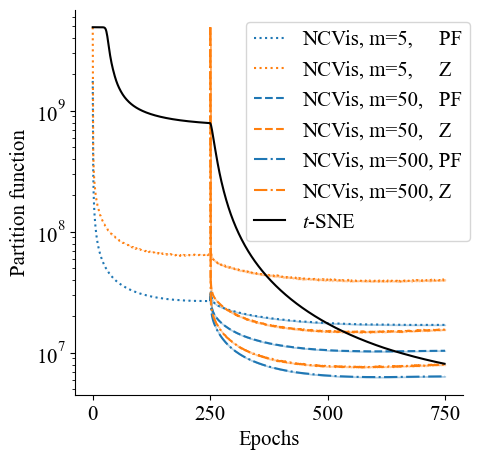

In [10]:
# plot partition functions and Zs
plt.figure(figsize=(5,5))
alpha=0.3
fontsize = 15
linestyles = ["dotted", "dashed", "dashdot"]

plt.plot(np.arange(250), nce_norms_init.mean(0), linestyle="dotted", c=cmap(0))
plt.fill_between(np.arange(250),
                 nce_norms_init.mean(0) + nce_norms_init.std(0),
                 nce_norms_init.mean(0) - nce_norms_init.std(0),
                 alpha=alpha)

plt.plot(np.arange(250), nce_zs_init.mean(0), linestyle="dotted", c=cmap(1))
plt.fill_between(np.arange(250),
                 nce_zs_init.mean(0) + nce_zs_init.std(0),
                 nce_zs_init.mean(0) - nce_zs_init.std(0),
                 alpha=alpha)

for i in range(len(embedders)):
    plt.plot(np.arange(250, 751),
             nce_norms.mean(0)[i],
             linestyle=linestyles[i],
             label=f"NCVis, m={nbs_noise[i]}, "+"  "*(2-i)+ "PF",
             c=cmap(0))

    plt.fill_between(np.arange(250, 751),
                     nce_norms.mean(0)[i] + nce_norms.std(0)[i],
                     nce_norms.mean(0)[i] - nce_norms.std(0)[i],
                     color=cmap(0),
                     alpha=alpha)

    plt.plot(np.arange(250, 751),
             nce_zs.mean(0)[i],
             linestyle=linestyles[i],
             label=f"NCVis, m={nbs_noise[i]}, "+"  "*(2-i)+ "Z",
             c=cmap(1))

    plt.fill_between(np.arange(250, 751),
                     nce_zs.mean(0)[i] + nce_zs.std(0)[i],
                     nce_zs.mean(0)[i] - nce_zs.std(0)[i],
                     color=cmap(1),
                     alpha=alpha)
plt.plot(tsne_data_list[0]["Zs"], label = r"$t$-SNE", c="k")
plt.legend(loc=(0.44,0.4), handlelength=1.5, fontsize=fontsize)

plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)

plt.yscale("log")
plt.xlabel("Epochs", fontsize=fontsize)
plt.xticks([0 ,250, 500, 750], fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.ylabel("Partition function", fontsize=fontsize)
plt.savefig(os.path.join(fig_path,
                         f"partition_Z_short.png"),
            bbox_inches='tight',
            pad_inches=0,
            dpi=200,
            transparent=False,
            facecolor='white')

# many epochs

## tSNE

In [11]:
n_early_epochs = 250
n_epochs = 9750
perplexity = 2*k
rescale_tsne = True

if rescale_tsne:
    pca_tsne = pca2 / np.std(pca2[:, 0]) / 10000
else:
    pca_tsne = pca2


affinities_tSNE = Affinities()
affinities_tSNE.P = (sknn_graph / sknn_graph.sum()).tocsr()
log_kl = False
log_embds = False
log_Z = True

tsne_data_long_list = []
for seed in seeds:
    file_name = os.path.join(root_path,
                             "mnist",
                             f"tsne_bin_k_{k}_n_epochs_{n_epochs}_n_early_epochs_{n_early_epochs}_perplexity_{perplexity}_seed_{seed}_log_kl_{log_kl}_log_embds_{log_embds}_init_pca_rescale_{rescale_tsne}.pkl")
    try:
        tsne_data_long = load_dict(file_name)
    except FileNotFoundError:
        tsne = TSNEwrapper(perplexity=perplexity,
                           metric="euclidean",
                           n_jobs=-1, # n_jobs=-10 does not work well, the cell does not print anything
                           random_state=seed,
                           verbose=True,
                           n_iter = n_epochs,
                           early_exaggeration_iter = n_early_epochs,
                           callbacks_every_iters=1,
                           log_kl=log_kl,
                           log_embds=log_embds,
                           log_Z=log_Z,
                           initialization=pca_tsne)
        embd = tsne.fit_transform(x, affinities=affinities_tSNE)

        save_dict(tsne.aux_data, file_name)
        tsne_data_long = tsne.aux_data
    tsne_data_long_list.append(tsne_data_long)

<AxesSubplot:>

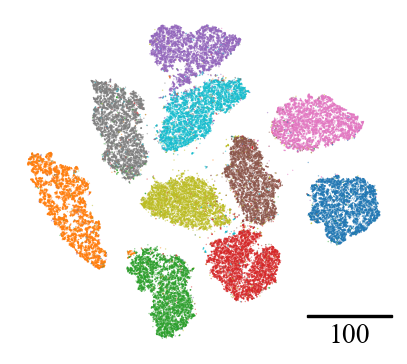

In [12]:
epoch = -1

plt.figure(figsize=(5,5))

plot_scatter(plt.gca(), tsne_data_long_list[2]["embd"], y )

## NCVis

In [17]:
parametric = False
log_embds = True
log_norms = True
log_kl = True
optimizer = "sgd"
n_epochs =  9750
loss_mode = "nce"
n_noise = 5
batch_size = 1024
rescale = 1.0
anneal_lr = True
momentum=0.0
lr_min_factor=0.0
clamp_low = 1e-10
on_gpu = True

embedders_init = []
embedders_long = []
for s in seeds:
    # load early exaggeration phase
    file_name_nce_5 = os.path.join(root_path,
                             dataset,
                             f"cne_{loss_mode}_n_noise_{5}_n_epochs_{250}_init_pca_rescale_{1.0}_bs_{batch_size}"
                             f"_optim_{optimizer}_anneal_lr_{anneal_lr}_lr_min_factor_{lr_min_factor}_momentum_{momentum}_param_{parametric}_clamp_low_{clamp_low}_seed_{s}.pkl"
                             )


    with open(file_name_nce_5, "rb") as file:
        embedder_nce_5 = pickle.load(file)
    embedders_init.append(embedder_nce_5)

    # load proper phase
    file_name_nce_500 = os.path.join(root_path,
                             dataset,
                             f"cne_{loss_mode}_n_noise_{500}_n_epochs_{n_epochs}_init_EE_bs_{batch_size}"
                             f"_optim_{optimizer}_anneal_lr_{anneal_lr}_lr_min_factor_{lr_min_factor}_momentum_{momentum}_param_{parametric}_clamp_low_{clamp_low}_seed_{s}.pkl"
                             )

    with open(file_name_nce_500, "rb") as file:
        embedder_nce_500 = pickle.load(file)
    embedders_long.append(embedder_nce_500)
    print(f"Done with seed {s}")

Done with seed 0
Done with seed 1
Done with seed 2


<AxesSubplot:>

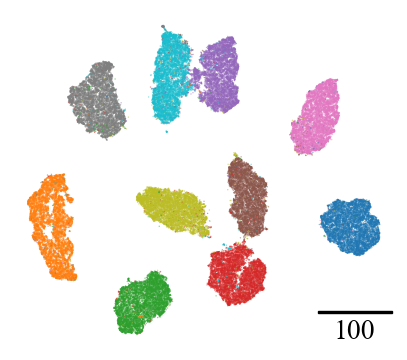

In [18]:
epoch = -1
plt.figure(figsize=(5,5))
plot_scatter(plt.gca(), embedders_long[0].callback.embds[-1], y )

In [19]:
times  = np.array([embedders_init[i].time + embedders_long[i].time for i in range(len(seeds))])

print(f"Mean time [min]: {times.mean()/60}")
print(f"Std time [min]:  {times.std()/60}")

Mean time [min]: 785.8325843175252
Std time [min]:  2.14431662277044


In [21]:
# read out norms and Z (and rescale the latter by the noise distribution)
norms_init = np.array([embedders_init[i].callback.norms[:-1] for i in range(len(seeds))])[:,:, 0]
zs_init = np.array([embedders_init[i].callback.Zs[:-1] for i in range(len(seeds))]) * len(x) * (len(x)-1)
norms_long = np.array([embedders_long[i].callback.norms for i in range(len(seeds))])[:, :, 0]
zs_long = np.array([embedders_long[i].callback.Zs for i in range(len(seeds))]) * len(x) * (len(x)-1)

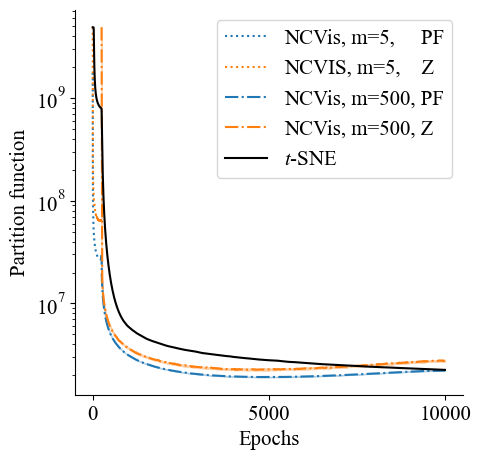

In [22]:
# plot partition and Z for long optimization
plt.figure(figsize=(5,5))
fontsize=15
alpha=0.3

plt.plot(np.arange(250),
         norms_init.mean(0),
         linestyle="dotted",
         c=cmap(0),
         label="NCVis, m=5,     PF")
plt.fill_between(np.arange(250),
                 norms_init.mean(0) + norms_init.std(0),
                 norms_init.mean(0) - norms_init.std(0),
                 alpha=alpha)

plt.plot(np.arange(250),
         zs_init.mean(0),
         linestyle="dotted",
         c=cmap(1),
         label = "NCVIS, m=5,    Z")
plt.fill_between(np.arange(250),
                 zs_init.mean(0) + zs_init.std(0),
                 zs_init.mean(0) - zs_init.std(0),
                 alpha=alpha)

plt.plot(np.arange(250, 10001),
         norms_long.mean(0),
         linestyle="dashdot",
         label=f"NCVis, m=500, PF",
         c=cmap(0))

plt.fill_between(np.arange(250, 10001),
                 norms_long.mean(0) + norms_long.std(0),
                 norms_long.mean(0) - norms_long.std(0),
                 color=cmap(0),
                 alpha=alpha)

plt.plot(np.arange(250, 10001)[::20],
         zs_long.mean(0)[::20],
         linestyle="dashdot",
         label=f"NCVis, m=500, Z",
         c=cmap(1))

plt.fill_between(np.arange(250, 10001),
                 zs_long.mean(0) + zs_long.std(0),
                 zs_long.mean(0) - zs_long.std(0),
                 color=cmap(1),
                 alpha=alpha)
plt.plot(tsne_data_long_list[0]["Zs"], label = r"$t$-SNE", c="k")
plt.yscale("log")
plt.legend(fontsize=fontsize)
plt.xlabel("Epochs", fontsize=fontsize)
plt.ylabel("Partition function", fontsize=fontsize)
plt.xticks([0, 5000, 10000], fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)

plt.savefig(os.path.join(fig_path,
                         f"partition_Z_long.png"),
            bbox_inches='tight',
            pad_inches=0,
            dpi=200,
            transparent=False,
            facecolor='white')
